##Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install geopandas
!pip install pyshp

# os
import os 
import random
import pickle
import zipfile
import math

# pandas, geopandas
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString
import shapefile
from pyproj import CRS, Transformer

# path
import pathlib
from glob import glob
from pathlib import Path

# numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# models (ensemble)
!pip install lightgbm
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

# warnings
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.2 MB/s 
     |████████████████████████████████| 16.7 MB 57.0 MB/s 
     |████████████████████████████████| 6.3 MB 46.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Hyperparameters Setting

In [ ]:
CFG = {
    'SEED': 41
}

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

## Fix RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

# DataLoad

In [ ]:
class DataLoader():

  def __init__(self, path):
    self.path = path
    
    try:
      self.data = pd.read_csv(path)
    except:
      try:
        self.data = pd.read_csv(path, encoding='cp949')
      except:
        try:
          with open(path, 'rb') as f:
            self.data = pickle.load(f)
        except:
          raise ValueError("Error")
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    return self.data.loc[idx]


In [ ]:
# hug_re 파일이 존재하면, bug_re 파일로 바로 진행, 없으면 bug_re 파일 생성 절차 진행
jeju_bug = DataLoader(str(path / 'bug_re' / 'jeju_bug.csv')).data
jeju_safe = DataLoader(str(path / 'safe_re' / 'jeju_safe.csv')).data

jeju_bug_distance = DataLoader(str(path / 'distance' / 'jeju_bug_distance.csv')).data
jeju_safe_distance = DataLoader(str(path / 'distance' / 'jeju_safe_distance.csv')).data

jeju_bug = jeju_bug[['WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'LOCAL_CD', 'LATITUDE', 'LONGITUDE', 'STATION_ID']]
jeju_safe = jeju_safe[['WKT', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'LOCAL_CD']]

jeju_bug = pd.concat([jeju_bug, jeju_bug_distance], axis=1)
jeju_safe = pd.concat([jeju_safe, jeju_safe_distance], axis=1)

aws = DataLoader(str(path / 'weather' / 'aws_df')).data
asos = DataLoader(str(path / 'weather' / 'asos_df')).data
station = DataLoader(str(path / 'station' / 'station.csv')).data

## EDA

In [ ]:
eda_list = glob(str(path / 'bug_re' / '*.csv'))

plt.figure(figsize=(30, 30))

for idx, path in enumerate(eda_list):
  df = pd.read_csv(path)
  df = df[['LATITUDE', 'LONGITUDE', 'STATION_ID']]
  plt.subplot(3, 5, idx+1)

  sns.scatterplot(data=df, x='LATITUDE', y='LONGITUDE', hue='STATION_ID', palette="Paired")
  plt.title(path.split('/')[-1].split('.')[0])

## Make Folder_'re'

In [ ]:
import re

def extract_lat_log(local_df):
  p = re.compile(r'[a-zA-Z(())]')

  lat_log = []
  for row in local_df.itertuples():

    lat, log = map(float, re.sub(p, '', row[1]).strip().split(' '))

    lat_log.append([lat, log])
  
  return np.array(lat_log)

In [ ]:
# jeju_safe는 아직 station이 없으므로 station 연결해야 함
select_cols = ['LATITUDE', 'LONGITUDE', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'STATION_ID']

# 지역별 반복 작업 들어가야 하는 구간
df_jeju_bug = jeju_bug[select_cols]

#asos = asos.drop(['STATION_NAME', 'LATITUDE', 'LONGITUDE', 'AWS_STATION_ID'], axis=1)

In [ ]:
#지역별 safe 반복 작업 들어가야 하는 구간
jeju_safe_coord = extract_lat_log(jeju_safe)
jeju_safe_coord

jeju_safe['LATITUDE'] = jeju_safe_coord[:, 0]
jeju_safe['LONGITUDE'] = jeju_safe_coord[:, 1]

#데이터 저장하는 구간
jeju_safe.to_csv(str(path / 'safe' / 'jeju_safe.csv'.split('/')[-1]), index=False)

In [ ]:
jeju_safe

,WKT,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,LOCAL_CD,WKT,InputID,MEAN,STDDEV,MIN,MAX,LATITUDE,LONGITUDE
0,POINT (879282.705843553 1484652.46680757),0,0,0,91,50110,POINT (879282.705843553 1484652.46680757),0,37117.748899,16412.779697,3675.263775,69232.975867,879282.705844,1.484652e+06
1,POINT (884557.161745425 1491034.3387086),0,0,0,91,50110,POINT (884557.161745425 1491034.3387086),0,32858.105210,14298.051542,4203.285997,62408.830664,884557.161745,1.491034e+06
2,POINT (891998.998526205 1496778.90768391),0,0,0,91,50110,POINT (891998.998526205 1496778.90768391),0,28805.009634,10751.427939,7294.294468,56735.754914,891998.998526,1.496779e+06
3,POINT (891175.30409544 1549479.46875473),0,0,0,91,50110,POINT (891175.30409544 1549479.46875473),0,66990.360069,8398.408920,4890.361694,79886.332406,891175.304095,1.549479e+06
4,POINT (890267.575158607 1482665.71301482),0,0,0,92,50110,POINT (890267.575158607 1482665.71301482),0,27798.086338,15496.554958,3213.972903,70739.416419,890267.575159,1.482666e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25232,POINT (935939.088568158 1481555.5249896),2,0,0,83,50130,POINT (935939.088568158 1481555.5249896),2,26413.457029,13818.143134,3287.666417,86465.262065,935939.088568,1.481556e+06
25233,POINT (935647.09790366 1483164.46557813),2,0,0,83,50130,POINT (935647.09790366 1483164.46557813),2,25621.282018,14059.652920,3547.171210,84968.418044,935647.097904,1.483164e+06
25234,POINT (927407.813999882 1482960.3276642),2,0,0,83,50130,POINT (927407.813999882 1482960.3276642),2,20329.523536,12838.645899,2244.535388,80790.511864,927407.814000,1.482960e+06
25235,POINT (926479.166434503 1484541.59334488),2,0,0,83,50130,POINT (926479.166434503 1484541.59334488),2,19260.019005,12921.211642,1014.581978,78956.422223,926479.166435,1.484542e+06


In [ ]:
def make_kmeans_station(station, path):
    # 지점 클러스터링
  X = np.array(station[['STATION_ID','LATITUDE', 'LONGITUDE']])

  kmeans = KMeans(n_clusters=95, random_state=41).fit(X[:, 1:3])

  X_label = kmeans.labels_[:, np.newaxis]

  label = np.concatenate([X, X_label], axis=1)

  label_df = pd.DataFrame(data=label, columns=['STATION_ID', 'LATITUDE', 'LONGITUDE', 'LABEL'])
  
  label_df[['STATION_ID','LABEL']] = label_df[['STATION_ID', 'LABEL']].astype(int) 
  sns.scatterplot(data=label_df, x='LATITUDE', y='LONGITUDE', hue='LABEL')

  label_dict = {}

  for row in label_df.itertuples():
    label_dict[row[4]] = row[1]

  with open(str(path / 'models' / 'kmeans'), 'wb') as f:
    pickle.dump(kmeans, f, pickle.HIGHEST_PROTOCOL)

  with open(str(path / 'models' / 'kmeans_label'), 'wb') as f:
    pickle.dump(label, f, pickle.HIGHEST_PROTOCOL)
  
  return kmeans, label_dict


def apply_kmeans_station(kmeans, label_dict, find_sec_path, save_sec_path):
  gis_csv_list = glob(str(path / find_sec_path / '*.csv'))
  gis_csv_list.sort()

  for gis in gis_csv_list:

    gis_df = pd.read_csv(gis)
    if 'STATION_ID' in gis_df.columns:
      gis_df = gis_df.drop(['STATION_ID'], axis=1)
    
    pred = gis_df[['LATITUDE', 'LONGITUDE']]
    pred_np = pred.to_numpy()

    pred_lat = pred_np[:, 0]
    pred_log = pred_np[:, 1]

    pred_cls_label = kmeans.predict(pred_np)

    pred_id = pd.DataFrame(data=[label_dict[row] for row in pred_cls_label], columns=['STATION_ID'])

    gis_df = pd.concat([gis_df, pred_id], axis=1)

    gis_df.to_csv(str(path / save_sec_path / gis.split('/')[-1]), index=False)

  sns.scatterplot(data=gis_df, x='LATITUDE', y='LONGITUDE', hue='STATION_ID', palette="Paired")

  return gis_df

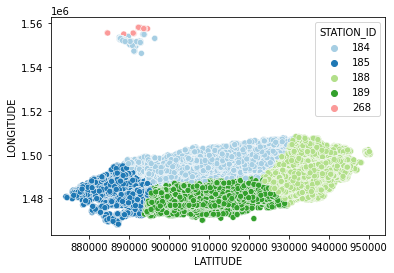

In [ ]:
# kmeans, label = make_kmeans_station(asos, path)

# apply_kmeans_station(kmeans, label, 'bug', 'bug_re')
# apply_kmeans_station(kmeans, label, 'safe', 'safe_re')

## Data-Preprocessing

In [ ]:
station = station.sort_values('DATE', ascending=False)

df = pd.DataFrame()

for idx, row in enumerate(df_jeju_bug.itertuples()):

  if idx % 10000 == 0:
    print(idx)

  tmp_df = asos[asos.STATION_ID == row[-1]].head(1)
  df = pd.concat([df, tmp_df])

df = df.reset_index(drop=True)
df_jeju_bug = pd.concat([df_jeju_bug, df], axis=1)

df_jeju_bug.to_csv(str(path / 'complete_bug_safe' / 'jeju_bug_com'), index=False)

In [ ]:
# safe file => 겹치는 부분이 존재하므로 safe 파일 이름을 변경한 후, 필요없는 데이터 제거, 순서를 jeju_bug_com과 동일하게 배치

jeju_bug_com = pd.read_csv(str(path / 'complete_bug_safe' / 'jeju_bug_com'))
jeju_bug_com = jeju_bug_com.drop(['DATE', 'LATITUDE.1','LONGITUDE.1'], axis=1)

jeju_safe = DataLoader(str(path / 'safe_re' / 'jeju_safe.csv')).data
jeju_safe = jeju_safe.drop(['WKT', 'LOCAL_CD', 'WKT.1', 'InputID'], axis=1)

jeju_bug_com = jeju_bug_com.drop(['STATION_ID.1', 'STATION_NAME'], axis=1)
jeju_bug_com

,LATITUDE,LONGITUDE,MEAN,STDDEV,MIN,MAX,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,STATION_ID
0,931986.0976,1.493221e+06,21670.411018,14936.276682,3789.676445,74640.432250,1,2,1,15,188
1,931979.0569,1.493212e+06,21665.190746,14933.273927,3796.465666,74643.485428,1,2,1,15,188
2,931979.0473,1.493210e+06,21665.000501,14933.005545,3798.392878,74645.091327,1,2,1,15,188
3,931976.0531,1.493211e+06,21663.226136,14932.370767,3796.628367,74642.500261,1,2,1,15,188
4,931973.0542,1.493211e+06,21661.357028,14931.601768,3795.829555,74640.712164,1,2,1,15,188
...,...,...,...,...,...,...,...,...,...,...,...
627714,933273.7579,1.493865e+06,22556.503535,15356.654285,3631.591634,74898.119861,1,2,3,77,188
627715,933272.7582,1.493865e+06,22555.849030,15356.403042,3631.442684,74897.508551,1,2,3,77,188
627716,890660.2425,1.482434e+06,27532.352175,15458.021850,3574.615103,70985.859034,1,2,1,15,185
627717,890651.3173,1.482449e+06,27536.886216,15457.190166,3567.039562,70970.467940,1,2,1,15,185


In [ ]:
def sort_ml_dataframe(data):
  data_dict = {'STATION_ID': data.STATION_ID, 'LATITUDE': data.LATITUDE, 'LONGITUDE': data.LONGITUDE,
               'STORUNST': data.STORUNST, 'FROR_CD': data.FROR_CD, 'FRTP_CD': data.FRTP_CD,
               'KOFTR_GROU': data.KOFTR_GROU, 'MEAN': data.MEAN, 'STDDEV': data.STDDEV,
               'MIN': data.MIN, 'MAX': data.MAX}
  
  return data_dict

jeju_bug_com = pd.DataFrame(data=sort_ml_dataframe(jeju_bug_com))
jeju_safe = pd.DataFrame(data=sort_ml_dataframe(jeju_safe))

In [ ]:
jeju_bug_com

,STATION_ID,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX
0,188,931986.0976,1.493221e+06,1,2,1,15,21670.411018,14936.276682,3789.676445,74640.432250
1,188,931979.0569,1.493212e+06,1,2,1,15,21665.190746,14933.273927,3796.465666,74643.485428
2,188,931979.0473,1.493210e+06,1,2,1,15,21665.000501,14933.005545,3798.392878,74645.091327
3,188,931976.0531,1.493211e+06,1,2,1,15,21663.226136,14932.370767,3796.628367,74642.500261
4,188,931973.0542,1.493211e+06,1,2,1,15,21661.357028,14931.601768,3795.829555,74640.712164
...,...,...,...,...,...,...,...,...,...,...,...
627714,188,933273.7579,1.493865e+06,1,2,3,77,22556.503535,15356.654285,3631.591634,74898.119861
627715,188,933272.7582,1.493865e+06,1,2,3,77,22555.849030,15356.403042,3631.442684,74897.508551
627716,185,890660.2425,1.482434e+06,1,2,1,15,27532.352175,15458.021850,3574.615103,70985.859034
627717,185,890651.3173,1.482449e+06,1,2,1,15,27536.886216,15457.190166,3567.039562,70970.467940


In [ ]:
jeju_safe

,STATION_ID,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX
0,185,879282.705844,1.484652e+06,0,0,0,91,37117.748899,16412.779697,3675.263775,69232.975867
1,185,884557.161745,1.491034e+06,0,0,0,91,32858.105210,14298.051542,4203.285997,62408.830664
2,184,891998.998526,1.496779e+06,0,0,0,91,28805.009634,10751.427939,7294.294468,56735.754914
3,184,891175.304095,1.549479e+06,0,0,0,91,66990.360069,8398.408920,4890.361694,79886.332406
4,185,890267.575159,1.482666e+06,0,0,0,92,27798.086338,15496.554958,3213.972903,70739.416419
...,...,...,...,...,...,...,...,...,...,...,...
25232,188,935939.088568,1.481556e+06,2,0,0,83,26413.457029,13818.143134,3287.666417,86465.262065
25233,188,935647.097904,1.483164e+06,2,0,0,83,25621.282018,14059.652920,3547.171210,84968.418044
25234,188,927407.814000,1.482960e+06,2,0,0,83,20329.523536,12838.645899,2244.535388,80790.511864
25235,188,926479.166435,1.484542e+06,2,0,0,83,19260.019005,12921.211642,1014.581978,78956.422223


In [ ]:
station = list(set(jeju_bug_com.STATION_ID))
station.sort()

station_dict = {}

for id in station:
  station_dict[str(id)] = asos[asos.STATION_ID == id].to_numpy()

cnt = 0

data_list = []
for row in jeju_bug_com.itertuples():
  cnt += 1

  if cnt % 100000 == 0:
    print(cnt)

  data_list.append(station_dict[str(row[1])])

data_list = np.array(data_list).reshape(-1, len(asos.columns))

tmp_df = pd.DataFrame(data=data_list, columns=asos.columns)

jeju_bug_com = pd.concat([jeju_bug_com, tmp_df], axis=1)

In [ ]:
jeju_bug_com

,STATION_ID,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,...,RF_AVG_03,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12
0,188,931986.0976,1.493221e+06,1,2,1,15,21670.411018,14936.276682,3789.676445,...,5.814516,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968
1,188,931979.0569,1.493212e+06,1,2,1,15,21665.190746,14933.273927,3796.465666,...,5.814516,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968
2,188,931979.0473,1.493210e+06,1,2,1,15,21665.000501,14933.005545,3798.392878,...,5.814516,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968
3,188,931976.0531,1.493211e+06,1,2,1,15,21663.226136,14932.370767,3796.628367,...,5.814516,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968
4,188,931973.0542,1.493211e+06,1,2,1,15,21661.357028,14931.601768,3795.829555,...,5.814516,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627714,188,933273.7579,1.493865e+06,1,2,3,77,22556.503535,15356.654285,3631.591634,...,5.814516,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968
627715,188,933272.7582,1.493865e+06,1,2,3,77,22555.849030,15356.403042,3631.442684,...,5.814516,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968
627716,185,890660.2425,1.482434e+06,1,2,1,15,27532.352175,15458.021850,3574.615103,...,3.258065,3.516667,2.330645,6.718182,4.532258,8.016129,11.2,0.451613,2.016667,0.790323
627717,185,890651.3173,1.482449e+06,1,2,1,15,27536.886216,15457.190166,3567.039562,...,3.258065,3.516667,2.330645,6.718182,4.532258,8.016129,11.2,0.451613,2.016667,0.790323


In [ ]:
station = list(set(jeju_safe.STATION_ID))
station.sort()

station_dict = {}

for id in station:
  station_dict[str(id)] = asos[asos.STATION_ID == id].to_numpy()

cnt = 0

data_list = []
for row in jeju_safe.itertuples():
  cnt += 1

  if cnt % 100000 == 0:
    print(cnt)

  data_list.append(station_dict[str(row[1])])

data_list = np.array(data_list).reshape(-1, len(asos.columns))

tmp_df = pd.DataFrame(data=data_list, columns=asos.columns)

jeju_safe = pd.concat([jeju_safe, tmp_df], axis=1)

In [ ]:
jeju_safe

,STATION_ID,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,...,RF_AVG_03,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12
0,185,879282.705844,1.484652e+06,0,0,0,91,37117.748899,16412.779697,3675.263775,...,3.258065,3.516667,2.330645,6.718182,4.532258,8.016129,11.2,0.451613,2.016667,0.790323
1,185,884557.161745,1.491034e+06,0,0,0,91,32858.105210,14298.051542,4203.285997,...,3.258065,3.516667,2.330645,6.718182,4.532258,8.016129,11.2,0.451613,2.016667,0.790323
2,184,891998.998526,1.496779e+06,0,0,0,91,28805.009634,10751.427939,7294.294468,...,3.959677,2.658333,2.024194,5.590909,7.967742,12.666667,19.95,1.919355,3.466667,1.032258
3,184,891175.304095,1.549479e+06,0,0,0,91,66990.360069,8398.408920,4890.361694,...,3.959677,2.658333,2.024194,5.590909,7.967742,12.666667,19.95,1.919355,3.466667,1.032258
4,185,890267.575159,1.482666e+06,0,0,0,92,27798.086338,15496.554958,3213.972903,...,3.258065,3.516667,2.330645,6.718182,4.532258,8.016129,11.2,0.451613,2.016667,0.790323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25232,188,935939.088568,1.481556e+06,2,0,0,83,26413.457029,13818.143134,3287.666417,...,5.814516,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968
25233,188,935647.097904,1.483164e+06,2,0,0,83,25621.282018,14059.652920,3547.171210,...,5.814516,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968
25234,188,927407.814000,1.482960e+06,2,0,0,83,20329.523536,12838.645899,2244.535388,...,5.814516,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968
25235,188,926479.166435,1.484542e+06,2,0,0,83,19260.019005,12921.211642,1014.581978,...,5.814516,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968


In [ ]:
jeju_bug_com = jeju_bug_com.drop(['STATION_ID'], axis=1)
jeju_safe = jeju_safe.drop(['STATION_ID'], axis=1)

jeju_df = jeju_df.reset_index(drop=True)

# 비감염(정상) = 1 감염(비정상) = 0
jeju_bug_com['LABEL'] = 0
jeju_safe['LABEL'] = 1

if jeju_bug_com.isnull().sum().sum() + jeju_safe.isnull().sum().sum() == 0:
  jeju_df = pd.concat([jeju_bug_com, jeju_safe], axis=0)
else:
  print('NULL 존재')

# jeju_df.to_csv(str(path / 'ml_data' / 'jeju_df.csv'), index=False)

# with open(str(path / 'ml_data' / 'jeju_df'), 'wb') as f:
#   pickle.dump(jeju_df, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# jeju_df.to_csv(str(path / 'ml_data' / 'jeju_df.csv'), index=False)

# with open(str(path / 'ml_data' / 'jeju_df'), 'wb') as f:
#   pickle.dump(jeju_df, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(str(path / 'ml_data' / 'jeju_df'), 'rb') as f:
  jeju_df = pickle.load(f)

In [ ]:
jeju_df.head()

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,LABEL
0,931986.0976,1.493221e+06,1,2,1,15,21670.411018,14936.276682,3789.676445,74640.432250,...,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968,1
1,931979.0569,1.493212e+06,1,2,1,15,21665.190746,14933.273927,3796.465666,74643.485428,...,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968,1
2,931979.0473,1.493210e+06,1,2,1,15,21665.000501,14933.005545,3798.392878,74645.091327,...,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968,1
3,931976.0531,1.493211e+06,1,2,1,15,21663.226136,14932.370767,3796.628367,74642.500261,...,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968,1
4,931973.0542,1.493211e+06,1,2,1,15,21661.357028,14931.601768,3795.829555,74640.712164,...,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968,1


In [ ]:
set(jeju_df.KOFTR_GROU)

In [ ]:
set(jeju_df.STORUNST)

{0, 1, 2}

In [ ]:
col_list = []
for idx, c in enumerate(jeju_df.columns):
  if c in ['STATION_NAME', 'LATITUDE', 'LONGITUDE']:
    print(idx)
  col_list.append(c)

col_list[10] = 'DROP'
col_list[202] = 'DROP'
col_list[203] = 'DROP'

jeju_df.columns = col_list
jeju_df = jeju_df.drop(['DROP'], axis=1)